## NOTE: Note that the GR6J model was simulated using R and then the predicted time series was imported here for the modeling process.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split, Dataset,TensorDataset
from sklearn.metrics import mean_squared_error

import random
import joblib
from google.colab import files
import matplotlib.dates as mdates

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:
import tensorflow as tf
seed = 311
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Prof Mwangi/Qdaily_1FG01_Yala_2014_2020.xlsx')

daily = data.iloc[:, [-4, -3, -2]]

discharge = daily.iloc[:1461, 2].to_numpy()
plui = daily.iloc[:1461, 0].to_numpy()
etp = daily.iloc[:1461, 1].to_numpy()

discharge1 = daily.iloc[1461:2191, 2].to_numpy()
plui1 = daily.iloc[1461:2191, 0].to_numpy()
etp1 = daily.iloc[1461:2191, 1].to_numpy()

In [ ]:
discharge[0]

np.float64(34.25915)

In [ ]:
#NSE, RMSE, R2
def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def calculate_r2(observed, predicted):

    mean_observed = np.mean(observed)
    mean_predicted = np.mean(predicted)

    numerator = np.sum((observed - mean_observed) * (predicted - mean_predicted))
    denominator = np.sqrt(np.sum((observed - mean_observed)**2)) * np.sqrt(np.sum((predicted - mean_predicted)**2))

    r2 = (numerator / denominator)**2
    return r2


GR6J

In [ ]:
GR6J = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HyMoLAP/Paper/Save/GR6J_cal_yala.xlsx')
GR6J_val = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HyMoLAP/Paper/Save/GR6J_val_yala.xlsx')

simGR6J = GR6J.to_numpy()
simGR6J_val = GR6J_val.to_numpy()

simGR6J = simGR6J.flatten()
simGR6J_val = simGR6J_val.flatten()

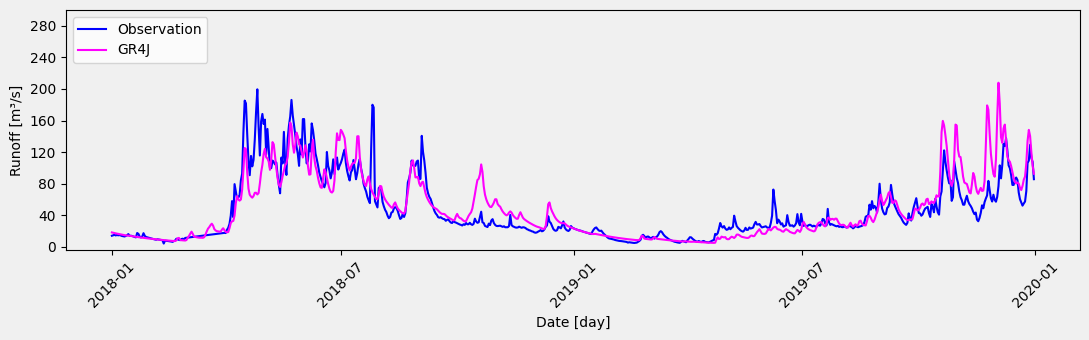

In [ ]:
# Generate dates
time1 = np.datetime64('2018-01-01')
time2 = np.datetime64('2019-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create figure and axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated discharge
ax.plot(time, discharge1, 'b',  label='Observation', linewidth=1.5)
ax.plot(time, simGR6J_val, 'magenta', label='GR4J', linewidth=1.5)

# X-axis parameters (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Y-axis parameters
ax.set_ylabel('Runoff [m³/s]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-4, 300)
ax.set_yticks(np.arange(0, 300, 40))

# Add legend
ax.legend(loc='upper left')

# Show grid
# plt.grid(True)

# Avoid overlaps
plt.tight_layout()

# Save figure
plt.savefig("Cauqueness_GR4J.jpeg", format='jpeg', dpi=700)

#files.download("Cauqueness_GR4J.jpeg")

ax.grid(False)

# Show plot
plt.show()


In [ ]:
#Calibration
simGR4J = simGR6J.flatten()
print('nashe=',nash_sutcliffe_efficiency(discharge, simGR4J))
print('rmse=',calculate_rmse(discharge, simGR4J))
print('r2=',calculate_r2(discharge, simGR4J))

nashe= 0.5529199425189717
rmse= 14.995432470300003
r2= 0.6022343956746167


In [ ]:
#Validation
simGR4J_val = simGR6J_val.flatten()
print('nashe=',nash_sutcliffe_efficiency(discharge1, simGR4J_val))
print('rmse=',calculate_rmse(discharge1, simGR4J_val))
print('r2=',calculate_r2(discharge1, simGR4J_val))

nashe= 0.6845965909151354
rmse= 22.1042844575488
r2= 0.7158937468881005


In [ ]:
Residu =  discharge - simGR6J
Residu1 = discharge1 - simGR6J_val

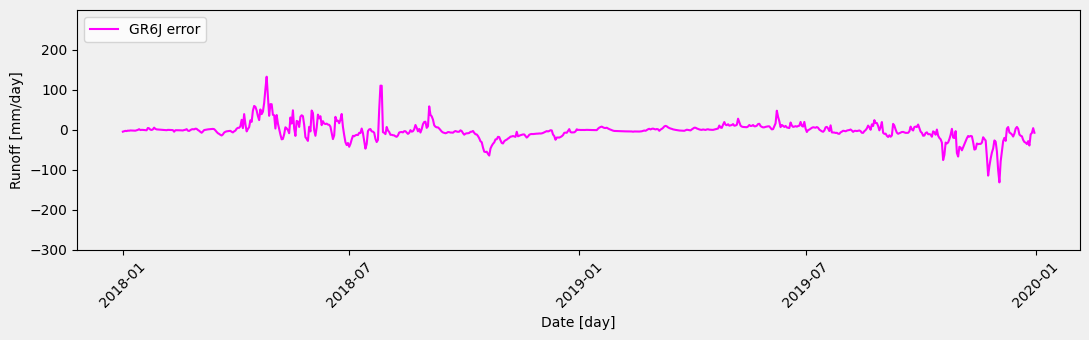

In [ ]:
# Generate dates
time1 = np.datetime64('2018-01-01')
time2 = np.datetime64('2019-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create figure and axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated discharge
#ax.plot(time, discharge1, 'b',  label='Observation', linewidth=1.5)
ax.plot(time,Residu1, 'magenta', label='GR6J error', linewidth=1.5)

# X-axis parameters (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Y-axis parameters
ax.set_ylabel('Runoff [mm/day]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-300, 300)
ax.set_yticks(np.arange(-300, 300, 100))

# Add legend
ax.legend(loc='upper left')

# Show grid
# plt.grid(True)

# Avoid overlaps
plt.tight_layout()


#files.download("Cauqueness_GR4J.jpeg")

# Show plot
plt.show()


GR6J_WKAN

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/KAN')

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.0 MB/s eta 0:00:00


In [ ]:
# ==========================================================
# 🔧 0️⃣ Imports & general settings
# ==========================================================
import os
# Optional: disable torch dynamo if you have already encountered the error
# os.environ["TORCH_DISABLE_DYNAMO"] = "1"

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import copy
import optuna
import matplotlib.pyplot as plt
import random
import pywt

from utils import EarlyStopping, KAN, KANLinear, kan_prediction_plots

# reproducibility
SEED = 142
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==========================================================
# 1️⃣ NSE
# ==========================================================
def nash_sutcliffe_efficiency(obs, sim):
    obs = np.array(obs)
    sim = np.array(sim)
    denom = np.sum((obs - np.mean(obs)) ** 2)
    if denom == 0:
        return -np.inf
    return 1 - np.sum((obs - sim) ** 2) / denom

# ==========================================================
# 2️⃣ DWT function (safe)
# ==========================================================
def apply_wavelet_safe(series, wavelet="db2", level=3):
    series = np.asarray(series)
    if len(series) == 0:
        return series
    # determine usable level
    try:
        max_level = pywt.dwt_max_level(len(series), pywt.Wavelet(wavelet).dec_len)
    except Exception:
        max_level = 0
    level_use = min(level, max_level) if max_level >= 1 else 0
    if level_use == 0:
        return series.copy()
    coeffs = pywt.wavedec(series, wavelet, level=level_use)
    coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]  # keep only approximation
    rec = pywt.waverec(coeffs, wavelet)
    rec = np.asarray(rec)
    # crop to original length (or smallest possible)
    return rec[:len(series)]

# ==========================================================
# 3️⃣ Data + Lag features
# NOTE: do NOT apply wavelet to the target (Residu / Residu1)
# ==========================================================
def prepare_data_kan(simGR4J, plui, etp, Residu,
                 simGR4J_val, plui1, etp1, Residu1,
                 lag=2, wavelet="db2", level=3):
    # --- harmonize lengths separately (train vs test) ---
    min_len_train = min(len(simGR4J), len(plui), len(etp), len(Residu))
    simGR4J = np.asarray(simGR4J)[:min_len_train]
    plui = np.asarray(plui)[:min_len_train]
    etp = np.asarray(etp)[:min_len_train]
    Residu = np.asarray(Residu)[:min_len_train]

    min_len_test = min(len(simGR4J_val), len(plui1), len(etp1), len(Residu1))
    simGR4J_val = np.asarray(simGR4J_val)[:min_len_test]
    plui1 = np.asarray(plui1)[:min_len_test]
    etp1 = np.asarray(etp1)[:min_len_test]
    Residu1 = np.asarray(Residu1)[:min_len_test]

    # --- apply DWT in "safe" mode if requested ---
    if wavelet is not None:
        Q_train = apply_wavelet_safe(simGR4J, wavelet, level)
        pl_train = apply_wavelet_safe(plui, wavelet, level)
        et_train = apply_wavelet_safe(etp, wavelet, level)

        Q_test = apply_wavelet_safe(simGR4J_val, wavelet, level)
        pl_test = apply_wavelet_safe(plui1, wavelet, level)
        et_test = apply_wavelet_safe(etp1, wavelet, level)
    else:
        Q_train, pl_train, et_train = simGR4J, plui, etp
        Q_test, pl_test, et_test = simGR4J_val, plui1, etp1

    # --- final cropping to ensure same lengths (train/test)
    min_len_train2 = min(len(Q_train), len(pl_train), len(et_train), len(Residu))
    Q_train = Q_train[:min_len_train2]
    pl_train = pl_train[:min_len_train2]
    et_train = et_train[:min_len_train2]
    Residu = Residu[:min_len_train2]

    min_len_test2 = min(len(Q_test), len(pl_test), len(et_test), len(Residu1))
    Q_test = Q_test[:min_len_test2]
    pl_test = pl_test[:min_len_test2]
    et_test = et_test[:min_len_test2]
    Residu1 = Residu1[:min_len_test2]

    data_train = pd.DataFrame({
        'Qsim': Q_train,
        'plui': pl_train,
        'etp': et_train,
        'target': Residu
    })
    data_test = pd.DataFrame({
        'Qsim': Q_test,
        'plui': pl_test,
        'etp': et_test,
        'target': Residu1
    })

    data = pd.concat([data_train, data_test], ignore_index=True)

    # --- create lag features if lag >= 1, otherwise keep raw variables ---
    if lag >= 1:
        for f in ['Qsim', 'plui', 'etp']:
            for l in range(1, lag + 1):
                data[f'{f}_lag{l}'] = data[f].shift(l)
        data = data.dropna().reset_index(drop=True)
    else:
        # lag == 0 -> keep raw columns (no shift)
        data = data.reset_index(drop=True)

    return data

# ==========================================================
# 4️⃣ Prepare train/test (return scalers like LSTM)
# ==========================================================
def Make_tidydata_for_kan(data_df, train_size=1280):
    df = data_df.copy().reset_index(drop=True)
    if train_size >= len(df):
        raise ValueError("train_size too large for the dataset size.")

    train_df = df.iloc[:train_size].copy().reset_index(drop=True)
    val_df = df.iloc[train_size:].copy().reset_index(drop=True)

    X_cols = [
    'Qsim','plui','etp'
    ] + [c for c in df.columns if c.startswith("Qsim_lag")
                         or c.startswith("plui_lag")
                         or c.startswith("etp_lag")]
    y_col = 'target'

    train_df['target_orig'] = train_df[y_col].values
    val_df['target_orig'] = val_df[y_col].values

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    scaler_X.fit(train_df[X_cols])
    scaler_y.fit(train_df[[y_col]])

    train_df[X_cols] = scaler_X.transform(train_df[X_cols])
    val_df[X_cols] = scaler_X.transform(val_df[X_cols])
    train_df[[y_col]] = scaler_y.transform(train_df[[y_col]])
    val_df[[y_col]] = scaler_y.transform(val_df[[y_col]])

    return train_df, val_df, scaler_X, scaler_y, X_cols

# ==========================================================
# 5️⃣ DataLoader & predict helper (KAN expects 2D X)
# ==========================================================
def data_loading(Xy_df, X_cols, y_col='target', batch_size=None, shuffle=False):
    X = Xy_df[X_cols].values.astype(np.float32)
    y = Xy_df[y_col].values.astype(np.float32).reshape(-1,1)
    dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
    if batch_size is None:
        batch_size = len(dataset)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def predict_all_kan(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            # KAN expects 2D input
            y_pred = model(Xb, update_grid=False)
            preds.append(y_pred)
            trues.append(yb)
    preds = torch.cat(preds, dim=0).cpu().numpy().flatten()
    trues = torch.cat(trues, dim=0).cpu().numpy().flatten()
    return preds, trues

# ==========================================================
# 6️⃣ train_test_loop_for_Q (save best model per trial)
# ==========================================================
def train_test_loop_for_Q(data_df, epochs, layers_hidden=[1,128,1], lr=0.001, batch_size=None,
                          train_size=1280, trial=None):
    train_df, val_df, scaler_X, scaler_y, X_cols = Make_tidydata_for_kan(data_df, train_size=train_size)
    train_loader = data_loading(train_df, X_cols, batch_size=batch_size, shuffle=True)
    val_loader = data_loading(val_df, X_cols, batch_size=batch_size, shuffle=False)

    input_size = train_df[X_cols].shape[1]
    local_layers_hidden = layers_hidden.copy()
    local_layers_hidden[0] = input_size

    Kan_network = KAN(layers_hidden=local_layers_hidden).to(torch.float32)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(Kan_network.parameters(), lr=lr)
    Kan_network.train()

    best_val_nse = -np.inf
    best_state = None

    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = Kan_network(X_batch, update_grid=False)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        y_val_pred_s, y_val_true_s = predict_all_kan(Kan_network, val_loader)
        y_val_pred = scaler_y.inverse_transform(y_val_pred_s.reshape(-1,1)).flatten()
        y_val_true = scaler_y.inverse_transform(y_val_true_s.reshape(-1,1)).flatten()
        nse_val = nash_sutcliffe_efficiency(y_val_true, y_val_pred)

        if nse_val > best_val_nse:
            best_val_nse = nse_val
            best_state = copy.deepcopy(Kan_network.state_dict())
            if trial is not None:
                # immediate save for this trial (guarantees exact recovery)
                model_path = f"best_model_trial_{trial.number}.pt"
                torch.save(best_state, model_path)

        if trial is not None:
            trial.report(nse_val, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

    # return the best NSE found for this training
    return best_val_nse

# ==========================================================
# 7️⃣ Wavelet + Optuna loop (same principle as LSTM)
# ==========================================================
wavelets = ["db2"]    # adjust if needed
levels = [5]             # adjust if needed
lag = 2
TRAIN_SIZE = 1461

best_global_val = -np.inf
best_wave, best_level, best_params = None, None, None
best_model_path_global = None

for wave in wavelets:
    for lev in levels:
        print(f"\n🌊 Wavelet={wave}, Level={lev}")
        data = prepare_data_kan(simGR4J, plui, etp, Residu,
                                simGR4J_val, plui1, etp1, Residu1,
                                lag=lag, wavelet=wave, level=lev)

        def objective(trial):
            n_units = trial.suggest_categorical("n_units", [16, 32, 64,128,256, 512])
            lr = trial.suggest_categorical("lr", [1e-3,1e-2])
            epochs_trial = trial.suggest_categorical("epochs", list(range(50,500,50)))
            batch_size_trial = trial.suggest_categorical("batch_size", [16, 32,64,128, 256,512])

            layers_hidden = [1, n_units, 1]

            nse_val = train_test_loop_for_Q(
                data_df=data,
                epochs=epochs_trial,
                layers_hidden=layers_hidden,
                lr=lr,
                batch_size=batch_size_trial,
                train_size=TRAIN_SIZE,
                trial=trial
            )

            # store the model saved during this trial (deterministic path)
            trial.set_user_attr("model_path", f"best_model_trial_{trial.number}.pt")
            return nse_val

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=200)   # change n_trials if needed

        best_trial = study.best_trial
        best_val_local = best_trial.value
        best_params_local = best_trial.params
        best_model_path_local = best_trial.user_attrs.get("model_path", None)

        print(f"✅ Wavelet={wave}, Level={lev} → NSE_val={best_val_local:.4f}, params={best_params_local}")

        if best_val_local > best_global_val:
            best_global_val = best_val_local
            best_wave = wave
            best_level = lev
            best_params = best_params_local
            best_model_path_global = best_model_path_local

print("\n🏆 BEST overall configuration:")
print(f"Wavelet={best_wave}, Level={best_level}, Params={best_params}, NSE_val={best_global_val:.4f}")
print(f"Best model path: {best_model_path_global}")

# ==========================================================
# 8️⃣ Load the exact best saved model and produce final predictions
# ==========================================================
if best_model_path_global is None:
    raise RuntimeError("No saved model found (best_model_path_global is None).")

# prepare final data (same wavelet & level)
data_final = prepare_data_kan(
    simGR4J, plui, etp, Residu,
    simGR4J_val, plui1, etp1, Residu1,
    lag=lag, wavelet=best_wave, level=best_level
)

train_df, val_df, scaler_X_final, scaler_y_final, X_cols_final = Make_tidydata_for_kan(
    data_final, train_size=TRAIN_SIZE
)

# ==========================================================
# 🔧 Rebuild the same architecture as the best model
# ==========================================================
best_n_units = int(best_params["n_units"])
input_size_final = len(X_cols_final)  # same number of inputs as during best trial
best_layers = [input_size_final, best_n_units, 1]

model_final = KAN(layers_hidden=best_layers).to(torch.float32)

# ✅ Load the model with tolerance on weight size
state_dict = torch.load(best_model_path_global, map_location="cpu")
model_final.load_state_dict(state_dict, strict=False)

# ==========================================================
# 📦 Final DataLoader
# ==========================================================
train_loader_final = data_loading(train_df, X_cols_final, batch_size=len(train_df), shuffle=False)
val_loader_final   = data_loading(val_df, X_cols_final, batch_size=len(val_df), shuffle=False)

# ==========================================================
# 🔮 Final predictions
# ==========================================================
res_pred_train_s, _ = predict_all_kan(model_final, train_loader_final)
res_pred_test_s, _  = predict_all_kan(model_final, val_loader_final)

# 🔁 Inverse transform outputs
res_pred_train = scaler_y_final.inverse_transform(res_pred_train_s.reshape(-1,1)).flatten()
res_pred_test  = scaler_y_final.inverse_transform(res_pred_test_s.reshape(-1,1)).flatten()
y_train_true   = scaler_y_final.inverse_transform(train_df[['target']]).flatten()
y_val_true     = scaler_y_final.inverse_transform(val_df[['target']]).flatten()

# ==========================================================
# 📈 Final evaluation
# ==========================================================
nse_train = nash_sutcliffe_efficiency(y_train_true, res_pred_train)
nse_val   = nash_sutcliffe_efficiency(y_val_true,   res_pred_test)

print(f"📊 Final NSE (train): {nse_train:.4f}")
print(f"📊 Final NSE (val)  : {nse_val:.4f}")

# ==========================================================
# 9️⃣ Visualization & saving
# ==========================================================
res_pred_train_df = pd.DataFrame({"obs": y_train_true, "pred": res_pred_train})
res_pred_test_df  = pd.DataFrame({"obs": y_val_true, "pred": res_pred_test})

print("\n✅ Best series saved in res_pred_train_df and res_pred_test_df")

plt.figure(figsize=(12,4))
plt.plot(y_val_true, label='True (val)', linewidth=1)
plt.plot(res_pred_test, label='Predicted (val)', linewidth=1, alpha=0.8)
plt.legend()
plt.title('Validation: True vs Predicted (original units) - Best model')
plt.show()


##residu plots

In [ ]:
# Validation Performance evaluation

nse_value = nash_sutcliffe_efficiency(Residu1[2:], res_pred_test)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(Residu1[2:], res_pred_test)
print('RMSE =', rmse)

r2 = calculate_r2(Residu1[2:], res_pred_test)
print('R² =', r2)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Generate dates
time1 = np.datetime64('2018-01-03')
time2 = np.datetime64('2019-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 5))

# Plot observed and simulated discharge
ax.plot(time, Residu1[2:], color='b', alpha=0.5, label=r"$\mathrm{Res}^{\mathrm{GR6J}}$", linewidth=2)
ax.plot(time, res_pred_test, color='red', alpha=0.8, label='Prediction (WKAN)', linewidth=2)

# Annotation
plt.text(0.02, 0.95, f"NSE = {0.22}\nRMSE = {69.72} m³/s",
         transform=plt.gca().transAxes, fontsize=13,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.85))

# X-axis parameters (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45, fontsize=12)
ax.set_xlabel('Date [day]', fontsize=14)

# Y-axis parameters
ax.set_ylabel('Residual error [m³/s]', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-600, 600)
ax.set_yticks(np.arange(-600, 601, 200))

# Add legend
#ax.legend(fontsize=13)

# Remove grid
ax.grid(False)

# Avoid overlaps
plt.tight_layout()

# Save figure
plt.savefig("Res_KAN.jpeg", format='jpeg', dpi=700)

# Télécharger le fichier dans Google Colab
from google.colab import files
#files.download('Res_KAN.jpeg')

# Show plot
plt.show()


In [ ]:
# Plot
plt.figure(figsize=(7, 5))
plt.hist(Residu1, bins=30, alpha=0.5, label=r"$\mathrm{Res}^{\mathrm{GR6J}}$", color='b')
plt.hist(res_pred_test, bins=30, alpha=0.8, label='Predicted (WKAN)', color='orange')

# Labels
plt.xlabel('Residual error [m³/s]', fontsize=14)
plt.ylabel('Frequency', fontsize=14)


plt.legend(loc='upper left', fontsize=13)
plt.grid(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

# Save figure
plt.savefig("His_WKAN_yala.jpeg", format='jpeg', dpi=700)
#files.download('His_WKAN_yala.jpeg')

plt.show()


Data reconstruction

In [ ]:
final_pred = simGR6J[2:] + res_pred_train[:-2]
final_pred1 = simGR6J_val[2:] + res_pred_test

In [ ]:
# Training Performance evaluation

nse_value = nash_sutcliffe_efficiency(discharge[2:],final_pred)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge[2:],final_pred)
print('RMSE =', rmse)

r2 = calculate_r2(discharge[2:],final_pred)
print('R² =', r2)

In [ ]:
# Validation Performance evaluation

nse_value = nash_sutcliffe_efficiency(discharge1[2:], final_pred1)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge1[2:], final_pred1)
print('RMSE =', rmse)

r2 = calculate_r2(discharge1[2:], final_pred1)
print('R² =', r2)

In [ ]:
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt

# Generate dates
time1 = np.datetime64('2018-01-03')
time2 = np.datetime64('2019-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create figure and axis
fig, ax = plt.subplots(figsize=(11, 4))

# Plot observed and simulated discharge
ax.plot(time, discharge1[2:], 'b', label='Observation', linewidth=1.8)
ax.plot(time, final_pred1, 'magenta', label='GR6J-WKAN', linewidth=1.8)

# X-axis parameters (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45, fontsize=13)
ax.set_xlabel('Date [day]', fontsize=14)

# Y-axis parameters
ax.set_ylabel('Runoff [m³/s]', fontsize=14)
ax.tick_params(axis='y', labelcolor='black', labelsize=12)
ax.set_ylim(-4, 300)
ax.set_yticks(np.arange(0, 300, 40))

# Add legend
ax.legend(loc='upper left', fontsize=13)

# Disable grid
ax.grid(False)

# Avoid overlaps
plt.tight_layout()

# Save figure
plt.savefig("GR6J_WKAN_yala.jpeg", format='jpeg', dpi=700)

#files.download('GR6J_WKAN_yala.jpeg')

# Show plot
plt.show()


In [ ]:
# Create a DataFrame to save the mean trajectory to an Excel file
df_mean_trajectory = pd.DataFrame({'GR6J_WKAN_yala': final_pred1})

# Save to an Excel file
df_mean_trajectory.to_excel('GR6J_WKAN_yala.xlsx', index=False)

# Download the file in Google Colab
#files.download('GR6J_WKAN_yala.xlsx')

(t-2) GR6J_WKAN

Nash-Sutcliffe Efficiency (NSE): 0.6237612552656366
RMSE = 13.76544501822758
R² = 0.6513248566232195

Nash-Sutcliffe Efficiency (NSE): 0.7222400022405423
RMSE = 20.753727338065065
R² = 0.7319416063877291


(t-2) GR6J_WKAN_P_PET : Wavelet=db2, Level=5, Params={'n_units': 32, 'lr': 0.01, 'epochs': 250, 'batch_size': 32}, NSE_val=0.2283

Nash-Sutcliffe Efficiency (NSE): 0.869598064566884
RMSE = 8.10402022765067
R² = 0.8718620556863582

Nash-Sutcliffe Efficiency (NSE): 0.76001999059713
RMSE = 19.29073564847466
R² = 0.7631049709843863